In [1]:
!pip install pandas numpy scikit-learn matplotlib ipywidgets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00


In [5]:
 from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


Random Forest Cross-Validation Metrics (5-fold):
Accuracy: 0.81 ± 0.03
Precision: 0.84 ± 0.04
Recall: 0.82 ± 0.04
F1-Score: 0.83 ± 0.02


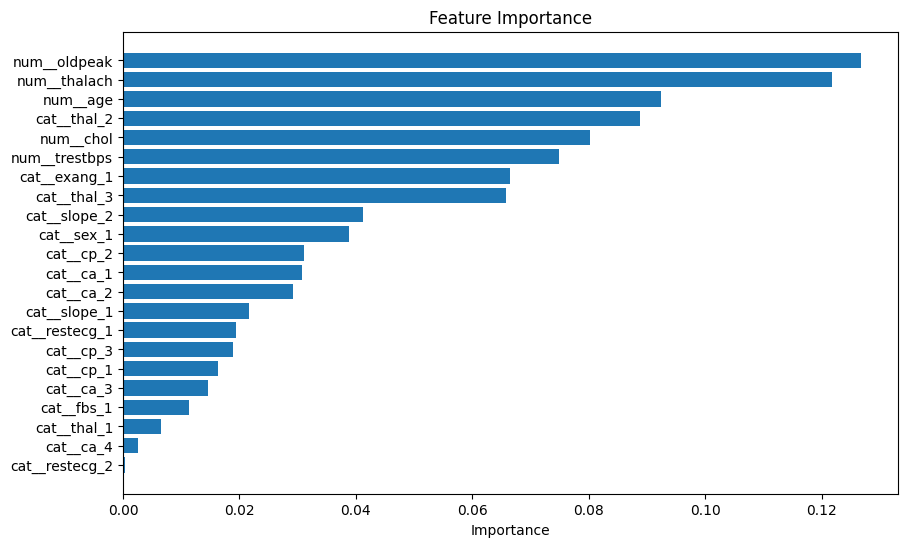

In [6]:
## Load Data, Train, and Evaluate
#Loads `heart.csv`, trains Random Forest, and performs 5-fold cross-validation.

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

# Load dataset
# Read the uploaded file into a pandas DataFrame
data = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

# Handle missing values
data = data.fillna({
    'age': data['age'].median(), 'trestbps': data['trestbps'].median(),
    'chol': data['chol'].median(), 'thalach': data['thalach'].median(),
    'oldpeak': data['oldpeak'].median(), 'sex': data['sex'].mode()[0],
    'cp': data['cp'].mode()[0], 'fbs': data['fbs'].mode()[0],
    'restecg': data['restecg'].mode()[0], 'exang': data['exang'].mode()[0],
    'slope': data['slope'].mode()[0], 'ca': data['ca'].mode()[0],
    'thal': data['thal'].mode()[0], 'target': data['target'].mode()[0]
})

# Train Random Forest
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
                  ('num', 'passthrough', numerical_cols)])
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
X = data.drop('target', axis=1)
y = data['target']
rf_pipeline.fit(X, y)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1_scores = [], [], [], []
for train_idx, test_idx in kf.split(data):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_pipeline.fit(X_train, y_train)
    predictions = rf_pipeline.predict(X_test)
    accuracies.append(accuracy_score(y_test, predictions))
    precisions.append(precision_score(y_test, predictions, zero_division=0))
    recalls.append(recall_score(y_test, predictions, zero_division=0))
    f1_scores.append(f1_score(y_test, predictions, zero_division=0))

print("Random Forest Cross-Validation Metrics (5-fold):")
print(f"Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
print(f"Precision: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}")
print(f"Recall: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}")
print(f"F1-Score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}")

# Feature importance
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [7]:
"""
## Interactive Diagnosis Interface
Provides a widget-based interface for predicting heart disease.
"""
output = widgets.Output()

def diagnose_patient(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal):
    with output:
        clear_output()
        try:
            # Input validation
            if not (0 <= age <= 120):
                raise ValueError("Age must be between 0 and 120.")
            if not (80 <= trestbps <= 200):
                raise ValueError("Resting BP must be between 80 and 200 mm Hg.")
            if not (100 <= chol <= 600):
                raise ValueError("Cholesterol must be between 100 and 600 mg/dl.")
            if not (60 <= thalach <= 220):
                raise ValueError("Max heart rate must be between 60 and 220 bpm.")
            if not (0 <= oldpeak <= 10):
                raise ValueError("ST depression must be between 0 and 10.")
            if not (0 <= ca <= 3):
                raise ValueError("Number of vessels must be between 0 and 3.")

            # Prepare input
            input_data = pd.DataFrame({
                'age': [age], 'sex': [sex], 'cp': [cp], 'trestbps': [trestbps],
                'chol': [chol], 'fbs': [fbs], 'restecg': [restecg], 'thalach': [thalach],
                'exang': [exang], 'oldpeak': [oldpeak], 'slope': [slope], 'ca': [ca], 'thal': [thal]
            })
            prob = rf_pipeline.predict_proba(input_data)[0]
            prediction = 'Heart Disease' if prob[1] > prob[0] else 'No Heart Disease'
            print(f"Prediction: {prediction}")
            print(f"Probability of Heart Disease: {prob[1]:.2f}")
            print(f"Probability of No Heart Disease: {prob[0]:.2f}")
        except Exception as e:
            print(f"Error: {str(e)}. Please check inputs.")

# Create input widgets
age_input = widgets.IntText(value=50, description='Age:', style={'description_width': '150px'})
sex_input = widgets.Dropdown(options=[('Male', 1), ('Female', 0)], description='Sex:', style={'description_width': '150px'})
cp_input = widgets.Dropdown(options=[('Typical', 0), ('Atypical', 1), ('Non-anginal', 2), ('Asymptomatic', 3)], description='Chest Pain:', style={'description_width': '150px'})
trestbps_input = widgets.IntText(value=120, description='Resting BP:', style={'description_width': '150px'})
chol_input = widgets.IntText(value=200, description='Cholesterol:', style={'description_width': '150px'})
fbs_input = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Fasting BS:', style={'description_width': '150px'})
restecg_input = widgets.Dropdown(options=[('Normal', 0), ('ST-T', 1), ('Hypertrophy', 2)], description='Resting ECG:', style={'description_width': '150px'})
thalach_input = widgets.IntText(value=150, description='Max HR:', style={'description_width': '150px'})
exang_input = widgets.Dropdown(options=[('No', 0), ('Yes', 1)], description='Ex. Angina:', style={'description_width': '150px'})
oldpeak_input = widgets.FloatText(value=0.0, description='ST Depression:', style={'description_width': '150px'})
slope_input = widgets.Dropdown(options=[('Downsloping', 0), ('Flat', 1), ('Upsloping', 2)], description='ST Slope:', style={'description_width': '150px'})
ca_input = widgets.IntText(value=0, description='Vessels (0-3):', style={'description_width': '150px'})
thal_input = widgets.Dropdown(options=[('Normal', 0), ('Fixed', 1), ('Reversible', 2), ('Unknown', 3)], description='Thalassemia:', style={'description_width': '150px'})
predict_button = widgets.Button(description='Predict', button_style='success', tooltip='Click to predict')

# Button handler
def on_predict_clicked(b):
    diagnose_patient(
        age_input.value, sex_input.value, cp_input.value, trestbps_input.value,
        chol_input.value, fbs_input.value, restecg_input.value, thalach_input.value,
        exang_input.value, oldpeak_input.value, slope_input.value, ca_input.value,
        thal_input.value
    )

predict_button.on_click(on_predict_clicked)

# Display interface
display(widgets.VBox([
    age_input, sex_input, cp_input, trestbps_input, chol_input,
    fbs_input, restecg_input, thalach_input, exang_input, oldpeak_input,
    slope_input, ca_input, thal_input, predict_button, output
]))